# Processing Set Visibility Tutorial

This tutorial can be run on Google Colaboratory via this [link](https://colab.research.google.com/github/casangi/xradio/blob/main/docs/source/measurement_set/tutorials/ps_vis.ipynb)



# Preparation

## Import xradio

In [1]:
import os, pprint
from importlib.metadata import version

try:
    os.system("pip install --upgrade xradio")

    import xradio

    print("Using xradio version", version("xradio"))

except ImportError as exc:
    print(f"Could not import xradio: {exc}")

Using xradio version 0.0.44


## Download example MSv2

In [2]:
import toolviper

toolviper.utils.data.download(file="Antennae_North.cal.lsrk.split.ms")

[2024-11-24 21:34:18,956]  WARNING   toolviper:  File exists: /home/fedemp/ws_xradio_dev/venv_xradio_python312/lib/python3.12/site-packages/toolviper/utils/data/.dropbox 
[2024-11-24 21:34:18,957]     INFO   toolviper:  Updating file metadata information ...  
 

 Download List                     
 ────────────────────────────────── 
  Antennae_North.cal.lsrk.split.ms

Antennae_North.cal.lsrk.split.ms.zip:   0%|          | 0.00/1.49M [00:00<?, ?iB/s]

# Processing Set

## Convert MSv2 => Processing Set (PS)

Before running the conversion function we can get an estimate of the resources that will be needed:

In [3]:
from xradio.measurement_set import estimate_conversion_memory_and_cores

msv2_name = "Antennae_North.cal.lsrk.split.ms"
mem_estimate, max_reasonable_cores, suggested_cores = estimate_conversion_memory_and_cores(msv2_name)
mem_estimate, max_reasonable_cores, suggested_cores

[2024-11-24 21:34:24,523]     INFO   toolviper:  Partition scheme that will be used: ['DATA_DESC_ID', 'OBS_MODE', 'OBSERVATION_ID', 'FIELD_ID'] 


(0.0004211299121379852, 12, 3)

The function used to estimate resources gives:
- an estimate of memory required in GiB,
- a maximum "reasonable" number of cores to use when converting in parallel, which is the number of partitions or MSv4s in the output processing set,
- and a suggested number of cores to use, as a rule of thumb the maximum / 4.

If we want to run the conversion in parallel, using Dask, we can initialize a "VIPER" client. In this example we use a local Dask client with the suggested number of cores = Dask workers:

In [ ]:
do_parallel = "none"
if do_parallel == "none":
    from toolviper import dask
    viper_client = toolviper.dask.local_client(cores=suggested_cores)

[2024-11-24 21:34:24,700]     INFO   toolviper:  Module path: /home/fedemp/ws_xradio_dev/venv_xradio_python312/lib/python3.12/site-packages/toolviper 
[2024-11-24 21:34:24,705]  WARNING      client:  It is recommended that the local cache directory be set using the dask_local_dir parameter. 
[2024-11-24 21:34:25,898]     INFO      client:  Client <MenrvaClient: 'tcp://127.0.0.1:39981' processes=3 threads=3, memory=5.45 GiB> 


Convert the example MeasurementSet v2 to Processing Set:

In [ ]:
from xradio.measurement_set import convert_msv2_to_processing_set

convert_out = "Antennae_North.cal.lsrk.split.vis.zarr"
convert_msv2_to_processing_set(
    in_file=msv2_name,
    out_file=convert_out,
    overwrite=True,
    parallel_mode=do_parallel,
)

[2024-11-24 21:34:25,912]     INFO      client:  Partition scheme that will be used: ['DATA_DESC_ID', 'OBS_MODE', 'OBSERVATION_ID', 'FIELD_ID'] 
[2024-11-24 21:34:25,991]     INFO      client:  Number of partitions: 12 
[2024-11-24 21:34:25,992]     INFO      client:  OBSERVATION_ID [0], DDI [0], STATE [32 23 30 37], FIELD [0], SCAN [ 9 17 21 25] 
[2024-11-24 21:34:25,993]     INFO      client:  OBSERVATION_ID [0], DDI [0], STATE [33 24 31], FIELD [1], SCAN [ 9 17 21] 
[2024-11-24 21:34:25,994]     INFO      client:  OBSERVATION_ID [0], DDI [0], STATE [34 25 32], FIELD [2], SCAN [ 9 17 21] 
[2024-11-24 21:34:25,995]     INFO      client:  OBSERVATION_ID [1], DDI [0], STATE [32 23 30 37], FIELD [0], SCAN [26 34 38 42] 
[2024-11-24 21:34:25,996]     INFO      client:  OBSERVATION_ID [1], DDI [0], STATE [33 24 31], FIELD [1], SCAN [26 34 38] 
[2024-11-24 21:34:25,997]     INFO      client:  OBSERVATION_ID [1], DDI [0], STATE [34 25 32], FIELD [2], SCAN [26 34 38] 
[2024-11-24 21:34:25,998

## Lazy open PS

In [6]:
from xradio.measurement_set import open_processing_set
convert_out = "Antennae_North.cal.lsrk.split.vis.zarr"

ps = open_processing_set(convert_out, intents=["OBSERVE_TARGET#ON_SOURCE"])

In [7]:
ps.summary()

,name,intents,shape,polarization,scan_number,spw_name,field_name,source_name,line_name,field_coords,start_frequency,end_frequency
6,Antennae_North.cal.lsrk.split_00,[OBSERVE_TARGET#ON_SOURCE],"(20, 45, 8, 2)","[XX, YY]","[9, 17, 21, 25]",spw_0,[NGC4038 - Antennae North_0],[NGC4038 - Antennae North_0],[],"[fk5, 12h01m52.43s, -18d52m02.92s]",3.439281e+11,3.440067e+11
4,Antennae_North.cal.lsrk.split_01,[OBSERVE_TARGET#ON_SOURCE],"(15, 45, 8, 2)","[XX, YY]","[9, 17, 21]",spw_0,[NGC4038 - Antennae North_1],[NGC4038 - Antennae North_0],[],"[fk5, 12h01m52.96s, -18d52m02.92s]",3.439281e+11,3.440067e+11
11,Antennae_North.cal.lsrk.split_02,[OBSERVE_TARGET#ON_SOURCE],"(15, 45, 8, 2)","[XX, YY]","[9, 17, 21]",spw_0,[NGC4038 - Antennae North_2],[NGC4038 - Antennae North_0],[],"[fk5, 12h01m53.49s, -18d52m02.92s]",3.439281e+11,3.440067e+11
1,Antennae_North.cal.lsrk.split_03,[OBSERVE_TARGET#ON_SOURCE],"(20, 55, 8, 2)","[XX, YY]","[26, 34, 38, 42]",spw_0,[NGC4038 - Antennae North_0],[NGC4038 - Antennae North_0],[],"[fk5, 12h01m52.43s, -18d52m02.92s]",3.439281e+11,3.440067e+11
5,Antennae_North.cal.lsrk.split_04,[OBSERVE_TARGET#ON_SOURCE],"(15, 55, 8, 2)","[XX, YY]","[26, 34, 38]",spw_0,[NGC4038 - Antennae North_1],[NGC4038 - Antennae North_0],[],"[fk5, 12h01m52.96s, -18d52m02.92s]",3.439281e+11,3.440067e+11
8,Antennae_North.cal.lsrk.split_05,[OBSERVE_TARGET#ON_SOURCE],"(15, 55, 8, 2)","[XX, YY]","[26, 34, 38]",spw_0,[NGC4038 - Antennae North_2],[NGC4038 - Antennae North_0],[],"[fk5, 12h01m53.49s, -18d52m02.92s]",3.439281e+11,3.440067e+11
7,Antennae_North.cal.lsrk.split_06,[OBSERVE_TARGET#ON_SOURCE],"(5, 55, 8, 2)","[XX, YY]",[43],spw_0,[NGC4038 - Antennae North_0],[NGC4038 - Antennae North_0],[],"[fk5, 12h01m52.43s, -18d52m02.92s]",3.439281e+11,3.440067e+11
10,Antennae_North.cal.lsrk.split_07,[OBSERVE_TARGET#ON_SOURCE],"(5, 55, 8, 2)","[XX, YY]",[43],spw_0,[NGC4038 - Antennae North_1],[NGC4038 - Antennae North_0],[],"[fk5, 12h01m52.96s, -18d52m02.92s]",3.439281e+11,3.440067e+11
0,Antennae_North.cal.lsrk.split_08,[OBSERVE_TARGET#ON_SOURCE],"(5, 55, 8, 2)","[XX, YY]",[43],spw_0,[NGC4038 - Antennae North_2],[NGC4038 - Antennae North_0],[],"[fk5, 12h01m53.49s, -18d52m02.92s]",3.439281e+11,3.440067e+11
9,Antennae_North.cal.lsrk.split_09,"[OBSERVE_TARGET#ON_SOURCE, CALIBRATE_WVR#ON_SO...","(20, 77, 8, 2)","[XX, YY]","[48, 56, 60, 64]",spw_0,[NGC4038 - Antennae North_0],[NGC4038 - Antennae North_0],[],"[fk5, 12h01m52.43s, -18d52m02.92s]",3.439281e+11,3.440067e+11


## PS Structure

A processing set is simply a dictionary of MSv4s (one per observation, field, intent, spectral window - polarization...):

In [8]:
len(ps)

12

In [9]:
ps.keys()

dict_keys(['Antennae_North.cal.lsrk.split_08', 'Antennae_North.cal.lsrk.split_03', 'Antennae_North.cal.lsrk.split_11', 'Antennae_North.cal.lsrk.split_10', 'Antennae_North.cal.lsrk.split_01', 'Antennae_North.cal.lsrk.split_04', 'Antennae_North.cal.lsrk.split_00', 'Antennae_North.cal.lsrk.split_06', 'Antennae_North.cal.lsrk.split_05', 'Antennae_North.cal.lsrk.split_09', 'Antennae_North.cal.lsrk.split_07', 'Antennae_North.cal.lsrk.split_02'])

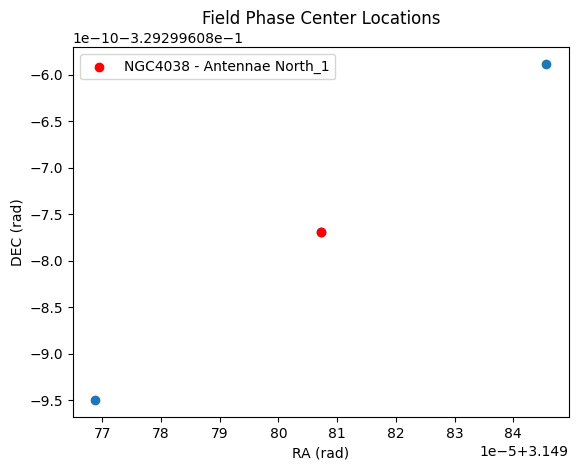

In [10]:
ps.plot_phase_centers()

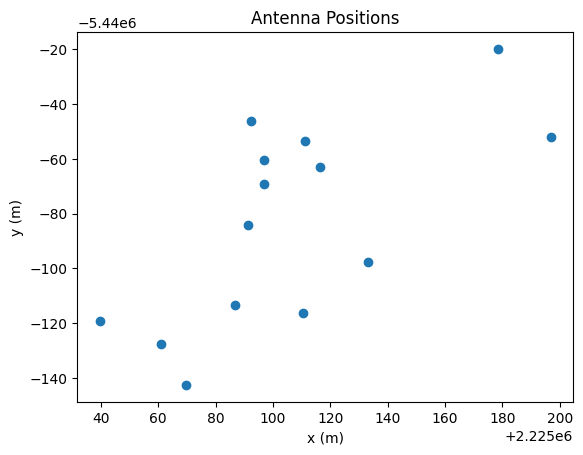

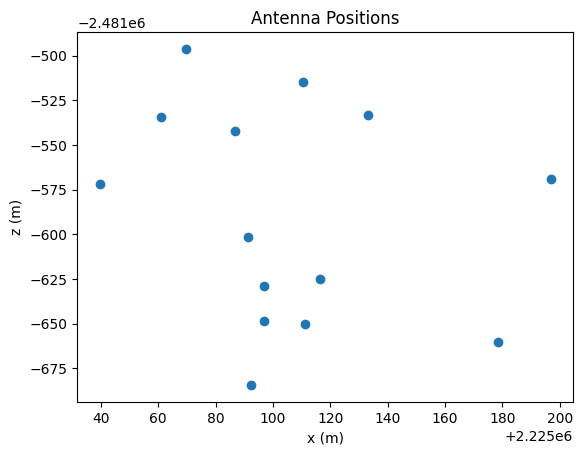

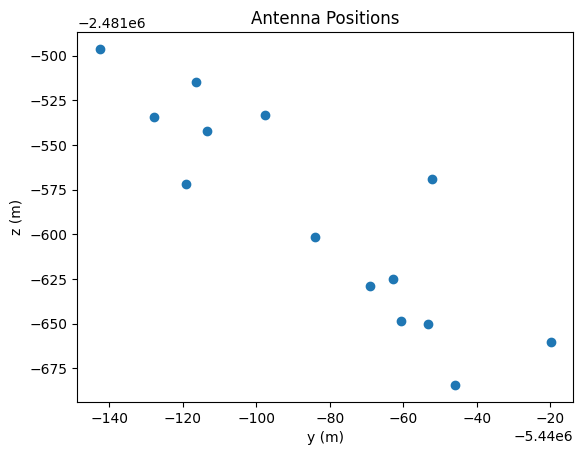

In [11]:
ps.plot_antenna_positions()

## MSv4


## Main dataset

We can take one of the items of the Processing Set to look into the contents of that MSv4. Every MSv4 represents the data as an xarray dataset, similarly as in earlier CNGI prototypes. The data variables (visibilities, weights, flags, etc.) can be manipulated and used in computations using the xarray API.

In [12]:
main_xds = ps[
    "Antennae_North.cal.lsrk.split_00"
]

### Coordinates

In [13]:
main_xds

<xarray.MeasurementSetXds> Size: 227kB
Dimensions:                     (baseline_id: 45, time: 20, frequency: 8,
                                 polarization: 2, uvw_label: 3)
Coordinates:
    baseline_antenna1_name      (baseline_id) <U9 2kB dask.array<chunksize=(45,), meta=np.ndarray>
    baseline_antenna2_name      (baseline_id) <U9 2kB dask.array<chunksize=(45,), meta=np.ndarray>
  * baseline_id                 (baseline_id) int64 360B 0 1 2 3 ... 41 42 43 44
    scan_number                 (time) int64 160B dask.array<chunksize=(20,), meta=np.ndarray>
  * time                        (time) float64 160B 1.307e+09 ... 1.307e+09
  * frequency                   (frequency) float64 64B 3.439e+11 ... 3.44e+11
  * polarization                (polarization) <U2 16B 'XX' 'YY'
  * uvw_label                   (uvw_label) <U1 12B 'u' 'v' 'w'
Data variables:
    EFFECTIVE_INTEGRATION_TIME  (time, baseline_id) float64 7kB dask.array<chunksize=(20, 45), meta=np.ndarray>
    FLAG                        (time, baseline_id, frequency, polarization) bool 14kB dask.array<chunksize=(20, 45, 8, 2), meta=np.ndarray>
    TIME_CENTROID               (time, baseline_id) float64 7kB dask.array<chunksize=(20, 45), meta=np.ndarray>
    UVW                         (time, baseline_id, uvw_label) float64 22kB dask.array<chunksize=(20, 45, 3), meta=np.ndarray>
    VISIBILITY                  (time, baseline_id, frequency, polarization) complex64 115kB dask.array<chunksize=(20, 45, 8, 2), meta=np.ndarray>
    WEIGHT                      (time, baseline_id, frequency, polarization) float32 58kB dask.array<chunksize=(20, 45, 8, 2), meta=np.ndarray>
Attributes:
    creation_date:     2024-11-24T20:34:27.872178+00:00
    data_groups:       {'base': {'correlated_data': 'VISIBILITY', 'flag': 'FL...
    observation_info:  {'observer': ['Unknown'], 'project': 'T.B.D.', 'releas...
    partition_info:    {'field_name': ['NGC4038 - Antennae North_0'], 'intent...
    processor_info:    {'sub_type': 'ALMA_CORRELATOR_MODE', 'type': 'CORRELAT...
    schema_version:    4.0.-9994
    type:              visibility
    xradio_version:    0.0.44
    antenna_xds:       <xarray.Dataset> Size: 2kB\nDimensions:               ...

In [14]:
main_xds.polarization

<xarray.DataArray 'polarization' (polarization: 2)> Size: 16B
array(['XX', 'YY'], dtype='<U2')
Coordinates:
  * polarization  (polarization) <U2 16B 'XX' 'YY'

In [15]:
main_xds.uvw_label

<xarray.DataArray 'uvw_label' (uvw_label: 3)> Size: 12B
array(['u', 'v', 'w'], dtype='<U1')
Coordinates:
  * uvw_label  (uvw_label) <U1 12B 'u' 'v' 'w'

In [16]:
main_xds.coords["baseline_id"]

<xarray.DataArray 'baseline_id' (baseline_id: 45)> Size: 360B
array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44])
Coordinates:
    baseline_antenna1_name  (baseline_id) <U9 2kB dask.array<chunksize=(45,), meta=np.ndarray>
    baseline_antenna2_name  (baseline_id) <U9 2kB dask.array<chunksize=(45,), meta=np.ndarray>
  * baseline_id             (baseline_id) int64 360B 0 1 2 3 4 ... 41 42 43 44

In [17]:
main_xds.time

<xarray.DataArray 'time' (time: 20)> Size: 160B
array([1.306547e+09, 1.306547e+09, 1.306547e+09, 1.306547e+09, 1.306547e+09,
       1.306549e+09, 1.306549e+09, 1.306549e+09, 1.306549e+09, 1.306549e+09,
       1.306550e+09, 1.306550e+09, 1.306550e+09, 1.306550e+09, 1.306550e+09,
       1.306551e+09, 1.306551e+09, 1.306551e+09, 1.306551e+09, 1.306551e+09])
Coordinates:
    scan_number  (time) int64 160B dask.array<chunksize=(20,), meta=np.ndarray>
  * time         (time) float64 160B 1.307e+09 1.307e+09 ... 1.307e+09 1.307e+09
Attributes:
    effective_integration_time:  EFFECTIVE_INTEGRATION_TIME
    format:                      unix
    integration_time:            {'attrs': {'type': 'quantity', 'units': ['s'...
    scale:                       utc
    type:                        time
    units:                       ['s']

### Data vars

In [18]:
main_xds.VISIBILITY

<xarray.DataArray 'VISIBILITY' (time: 20, baseline_id: 45, frequency: 8,
                                polarization: 2)> Size: 115kB
dask.array<open_dataset-VISIBILITY, shape=(20, 45, 8, 2), dtype=complex64, chunksize=(20, 45, 8, 2), chunktype=numpy.ndarray>
Coordinates:
    baseline_antenna1_name  (baseline_id) <U9 2kB dask.array<chunksize=(45,), meta=np.ndarray>
    baseline_antenna2_name  (baseline_id) <U9 2kB dask.array<chunksize=(45,), meta=np.ndarray>
  * baseline_id             (baseline_id) int64 360B 0 1 2 3 4 ... 41 42 43 44
    scan_number             (time) int64 160B dask.array<chunksize=(20,), meta=np.ndarray>
  * time                    (time) float64 160B 1.307e+09 ... 1.307e+09
  * frequency               (frequency) float64 64B 3.439e+11 ... 3.44e+11
  * polarization            (polarization) <U2 16B 'XX' 'YY'
Attributes:
    type:                  quanta
    units:                 ['unkown']
    field_and_source_xds:  <xarray.Dataset> Size: 264B\nDimensions:          ...

In [19]:
main_xds.FLAG

<xarray.DataArray 'FLAG' (time: 20, baseline_id: 45, frequency: 8,
                          polarization: 2)> Size: 14kB
dask.array<open_dataset-FLAG, shape=(20, 45, 8, 2), dtype=bool, chunksize=(20, 45, 8, 2), chunktype=numpy.ndarray>
Coordinates:
    baseline_antenna1_name  (baseline_id) <U9 2kB dask.array<chunksize=(45,), meta=np.ndarray>
    baseline_antenna2_name  (baseline_id) <U9 2kB dask.array<chunksize=(45,), meta=np.ndarray>
  * baseline_id             (baseline_id) int64 360B 0 1 2 3 4 ... 41 42 43 44
    scan_number             (time) int64 160B dask.array<chunksize=(20,), meta=np.ndarray>
  * time                    (time) float64 160B 1.307e+09 ... 1.307e+09
  * frequency               (frequency) float64 64B 3.439e+11 ... 3.44e+11
  * polarization            (polarization) <U2 16B 'XX' 'YY'

In [20]:
main_xds.VISIBILITY.max()

<xarray.DataArray 'VISIBILITY' ()> Size: 8B
dask.array<_nanmax_skip-aggregate, shape=(), dtype=complex64, chunksize=(), chunktype=numpy.ndarray>

In [21]:
main_xds.VISIBILITY.max().compute()
# main_xds.VISIBILITY.max().values

<xarray.DataArray 'VISIBILITY' ()> Size: 8B
array(6.4229984+0.10052532j, dtype=complex64)

## Metadata

The MS metadata can be found in the attributes of the `main_xds`. Metadata is stored in differente ways:
- in additional xarray sub-datasets, "sub-xds"
- in attributes of coordinates and data variables
- in Python dictionaries.

Most sub-xds are found in the attributes of the `main_xds`, but there are also sub-xds in the attributes of some data variables.
An example of sub-xds of the `main_xds` is the antenna dataset (`antenna_xds`). An example of dictionary is the `partition_info` dict.

### Metadata in sub-xds. Antenna dataset

The MSv4 has xarray datasets in its attributes that represent metadata where n-dimensional arrays is included. Some examples are the `antenna_xds`, `weather_xds` and `pointing_xds`. This would be the equivalent to some subtables of the MSv2. Let's look into the antenna sub-xds:


In [22]:
ant_xds = main_xds.attrs["antenna_xds"]

In [23]:
ant_xds

<xarray.Dataset> Size: 2kB
Dimensions:                 (antenna_name: 10, cartesian_pos_label: 3,
                             receptor_label: 2)
Coordinates:
  * antenna_name            (antenna_name) <U9 360B 'DV02_A015' ... 'PM03_J504'
  * cartesian_pos_label     (cartesian_pos_label) <U1 12B 'x' 'y' 'z'
    mount                   (antenna_name) <U6 240B dask.array<chunksize=(10,), meta=np.ndarray>
    polarization_type       (antenna_name, receptor_label) <U1 80B dask.array<chunksize=(10, 2), meta=np.ndarray>
  * receptor_label          (receptor_label) <U5 40B 'pol_0' 'pol_1'
    station                 (antenna_name) <U4 160B dask.array<chunksize=(10,), meta=np.ndarray>
    telescope_name          (antenna_name) <U4 160B dask.array<chunksize=(10,), meta=np.ndarray>
Data variables:
    ANTENNA_DISH_DIAMETER   (antenna_name) float64 80B dask.array<chunksize=(10,), meta=np.ndarray>
    ANTENNA_POSITION        (antenna_name, cartesian_pos_label) float64 240B dask.array<chunksize=(10, 3), meta=np.ndarray>
    ANTENNA_RECEPTOR_ANGLE  (antenna_name, receptor_label) float64 160B dask.array<chunksize=(10, 2), meta=np.ndarray>
Attributes:
    overall_telescope_name:  ALMA
    relocatable_antennas:    True
    type:                    antenna

As an xarray dataset, the antenna sub-xds can be used via the same API as the main xds.

In [24]:
ant_xds.ANTENNA_POSITION  # .values to load and see them

<xarray.DataArray 'ANTENNA_POSITION' (antenna_name: 10, cartesian_pos_label: 3)> Size: 240B
dask.array<open_dataset-ANTENNA_POSITION, shape=(10, 3), dtype=float64, chunksize=(10, 3), chunktype=numpy.ndarray>
Coordinates:
  * antenna_name         (antenna_name) <U9 360B 'DV02_A015' ... 'PM03_J504'
  * cartesian_pos_label  (cartesian_pos_label) <U1 12B 'x' 'y' 'z'
    mount                (antenna_name) <U6 240B dask.array<chunksize=(10,), meta=np.ndarray>
    station              (antenna_name) <U4 160B dask.array<chunksize=(10,), meta=np.ndarray>
    telescope_name       (antenna_name) <U4 160B dask.array<chunksize=(10,), meta=np.ndarray>
Attributes:
    coordinate_system:   geocentric
    frame:               GRS80
    origin_object_name:  earth
    type:                location
    units:               ['m', 'm', 'm']

In [25]:
ant_xds.antenna_name.values

array(['DV02_A015', 'DV06_T704', 'DV07_A004', 'DV08_A072', 'DV09_A008',
       'DV10_A009', 'DV11_A016', 'PM01_T702', 'PM02_A017', 'PM03_J504'],
      dtype='<U9')

In [26]:
ant_xds.ANTENNA_DISH_DIAMETER

<xarray.DataArray 'ANTENNA_DISH_DIAMETER' (antenna_name: 10)> Size: 80B
dask.array<open_dataset-ANTENNA_DISH_DIAMETER, shape=(10,), dtype=float64, chunksize=(10,), chunktype=numpy.ndarray>
Coordinates:
  * antenna_name    (antenna_name) <U9 360B 'DV02_A015' ... 'PM03_J504'
    mount           (antenna_name) <U6 240B dask.array<chunksize=(10,), meta=np.ndarray>
    station         (antenna_name) <U4 160B dask.array<chunksize=(10,), meta=np.ndarray>
    telescope_name  (antenna_name) <U4 160B dask.array<chunksize=(10,), meta=np.ndarray>
Attributes:
    type:     quantity
    units:    ['m']

In [27]:
ant_xds.ANTENNA_RECEPTOR_ANGLE

<xarray.DataArray 'ANTENNA_RECEPTOR_ANGLE' (antenna_name: 10, receptor_label: 2)> Size: 160B
dask.array<open_dataset-ANTENNA_RECEPTOR_ANGLE, shape=(10, 2), dtype=float64, chunksize=(10, 2), chunktype=numpy.ndarray>
Coordinates:
  * antenna_name       (antenna_name) <U9 360B 'DV02_A015' ... 'PM03_J504'
    mount              (antenna_name) <U6 240B dask.array<chunksize=(10,), meta=np.ndarray>
    polarization_type  (antenna_name, receptor_label) <U1 80B dask.array<chunksize=(10, 2), meta=np.ndarray>
  * receptor_label     (receptor_label) <U5 40B 'pol_0' 'pol_1'
    station            (antenna_name) <U4 160B dask.array<chunksize=(10,), meta=np.ndarray>
    telescope_name     (antenna_name) <U4 160B dask.array<chunksize=(10,), meta=np.ndarray>
Attributes:
    type:     quantity
    units:    ['rad']

### Attributes of Data Arrays and Coordinates. Quantities and Measures

Data variables and coordinates can have quantity and measures information in their attributes section along with other relevant metadata. These measures are specified as dictionaries in the attribute of the data variable or coordinate, with keys `units` and `type` in addition to other keys depending on the type of measure. The naming conventions are based on `astropy`. For example a quantity of casacore/`position` type, such as the antenna positions, is a measure with `type: "location"`

For reference, this is the list of measures in the current Processing Set/MSv4 spec:
https://docs.google.com/spreadsheets/d/1KIaYp6Qru1appToleyVqRdOEy9hmPhirpg0yR3ovAx0/edit?gid=1504318014#gid=1504318014, with naming conventions based on astropy. For example, a casacore `direction` is a `sky_coord`.



#### Time coordinate
The time coordinate is a time measure (keys: `type`, `units`, `time_scale`, `format`) but also contains for example `integration_time` which is a quantity.

In [28]:
main_xds.time

<xarray.DataArray 'time' (time: 20)> Size: 160B
array([1.306547e+09, 1.306547e+09, 1.306547e+09, 1.306547e+09, 1.306547e+09,
       1.306549e+09, 1.306549e+09, 1.306549e+09, 1.306549e+09, 1.306549e+09,
       1.306550e+09, 1.306550e+09, 1.306550e+09, 1.306550e+09, 1.306550e+09,
       1.306551e+09, 1.306551e+09, 1.306551e+09, 1.306551e+09, 1.306551e+09])
Coordinates:
    scan_number  (time) int64 160B dask.array<chunksize=(20,), meta=np.ndarray>
  * time         (time) float64 160B 1.307e+09 1.307e+09 ... 1.307e+09 1.307e+09
Attributes:
    effective_integration_time:  EFFECTIVE_INTEGRATION_TIME
    format:                      unix
    integration_time:            {'attrs': {'type': 'quantity', 'units': ['s'...
    scale:                       utc
    type:                        time
    units:                       ['s']

##### Quantities and measures that are not xarray

When a quantity or a measure is not an xarray, it is specificed as a dictionary with a format based on xarray's [xarray.DataArray.from_dict()](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.from_dict.html) and it has the following keys:
`{"dims": ..., "data": ..., "attrs": quantity/measures_dict}`. The `integration_time` attribute included in the  attributes of the time coordinate is an example where we can see the metadata of a time measure:

In [29]:
pprint.pprint(main_xds.time.attrs)

{'effective_integration_time': 'EFFECTIVE_INTEGRATION_TIME',
 'format': 'unix',
 'integration_time': {'attrs': {'type': 'quantity', 'units': ['s']},
                      'data': 6.048,
                      'dims': []},
 'scale': 'utc',
 'type': 'time',
 'units': ['s']}


#### Frequency coordinate

The `frequency` coordinate is a `spectral_coord` measure and as such has the following keys in its attributes: `type`, `units`, and `observer`. In addition, the attributes contain fields such as `channel_width`, `spectral_window_name`, and `reference_frequency`.

Any metadata that is a quantity or measure (non-id numbers) is placed in the relevant measures or quantity dictionary.

In [30]:
main_xds.frequency

<xarray.DataArray 'frequency' (frequency: 8)> Size: 64B
array([3.439281e+11, 3.439393e+11, 3.439506e+11, 3.439618e+11, 3.439730e+11,
       3.439843e+11, 3.439955e+11, 3.440067e+11])
Coordinates:
  * frequency  (frequency) float64 64B 3.439e+11 3.439e+11 ... 3.44e+11 3.44e+11
Attributes:
    channel_width:         {'attrs': {'type': 'quantity', 'units': ['Hz']}, '...
    observer:              lsrk
    reference_frequency:   {'attrs': {'observer': 'lsrk', 'type': 'spectral_c...
    spectral_window_id:    0
    spectral_window_name:  spw_0
    type:                  spectral_coord
    units:                 ['Hz']

In the frequency coordinate we have example of:
- quantity given as a dict: `channel_width`
- measure given as a dict: `reference_frequency` (a `spectral_coord` ~= casacore/frequency)

In [31]:
pprint.pprint(main_xds.frequency.attrs)

{'channel_width': {'attrs': {'type': 'quantity', 'units': ['Hz']},
                   'data': 11231488.981445312,
                   'dims': []},
 'observer': 'lsrk',
 'reference_frequency': {'attrs': {'observer': 'lsrk',
                                   'type': 'spectral_coord',
                                   'units': ['Hz']},
                         'data': 343928096685.9587,
                         'dims': []},
 'spectral_window_id': 0,
 'spectral_window_name': 'spw_0',
 'type': 'spectral_coord',
 'units': ['Hz']}


### Metadata in dicts. Observation, processor and partition info.

The MSv4 also allows for info dictionaries in the attribute section of the dataset. This is used when no n-dimensional data is required. The relevant measures metadata is included, similarly as with coordinates and data variables (when non-id) in xarray datasets.

An MSv4 has observation and processor info dicts, for example:

In [32]:
main_xds.observation_info

{'observer': ['Unknown'],
 'project': 'T.B.D.',
 'release_date': '1858-11-17T00:00:00.000000000'}

In [33]:
main_xds.processor_info

{'sub_type': 'ALMA_CORRELATOR_MODE', 'type': 'CORRELATOR'}

Another example is the `partition_info` dict, which describes the partition of the original MSv2 that is included in the `main_xds`:

In [34]:
main_xds.partition_info

{'field_name': ['NGC4038 - Antennae North_0'],
 'intents': ['OBSERVE_TARGET#ON_SOURCE'],
 'line_name': [],
 'polarization_setup': ['XX', 'YY'],
 'scan_number': [9, 17, 21, 25],
 'source_name': ['NGC4038 - Antennae North_0'],
 'spectral_window_name': 'spw_0',
 'taql': 'WHERE (DATA_DESC_ID IN [0]) AND(OBSERVATION_ID IN [0]) AND(STATE_ID IN [32,23,30,37]) AND(FIELD_ID IN [0]) AND(SCAN_NUMBER IN [9,17,21,25]) AND(STATE_ID IN [32,23,30,37]) '}

### Metadata in sub-xds of data variables. Field_and_source sub-dataset.

A special example of sub-xds is the `xds` which is included in the attributes of the VISIBILITY data variable. This way, transformations applied on the visibilities can be reflected in variables such as the field phase center or the source direction. Here data variables such as `FIELD_PHASE_CENTER` or `SOURCE_DIRECTION` are stored as `sky_coord` measures (their attributes contain the following keys: `type`, `units`, `frame`).

In [35]:
field_and_source_xds = main_xds.VISIBILITY.field_and_source_xds

In [36]:
field_and_source_xds

<xarray.Dataset> Size: 264B
Dimensions:             (sky_dir_label: 2)
Coordinates:
    field_name          <U26 104B ...
  * sky_dir_label       (sky_dir_label) <U3 24B 'ra' 'dec'
    source_name         <U26 104B ...
Data variables:
    FIELD_PHASE_CENTER  (sky_dir_label) float64 16B dask.array<chunksize=(2,), meta=np.ndarray>
    SOURCE_LOCATION     (sky_dir_label) float64 16B dask.array<chunksize=(2,), meta=np.ndarray>
Attributes:
    is_ephemeris:  False
    type:          field_and_source

In [37]:
field_and_source_xds.FIELD_PHASE_CENTER

<xarray.DataArray 'FIELD_PHASE_CENTER' (sky_dir_label: 2)> Size: 16B
dask.array<open_dataset-FIELD_PHASE_CENTER, shape=(2,), dtype=float64, chunksize=(2,), chunktype=numpy.ndarray>
Coordinates:
    field_name     <U26 104B ...
  * sky_dir_label  (sky_dir_label) <U3 24B 'ra' 'dec'
    source_name    <U26 104B ...
Attributes:
    frame:    fk5
    type:     sky_coord
    units:    ['rad', 'rad']

In [38]:
field_and_source_xds.SOURCE_LOCATION

<xarray.DataArray 'SOURCE_LOCATION' (sky_dir_label: 2)> Size: 16B
dask.array<open_dataset-SOURCE_LOCATION, shape=(2,), dtype=float64, chunksize=(2,), chunktype=numpy.ndarray>
Coordinates:
    field_name     <U26 104B ...
  * sky_dir_label  (sky_dir_label) <U3 24B 'ra' 'dec'
    source_name    <U26 104B ...
Attributes:
    frame:    fk5
    type:     sky_coord
    units:    ['rad', 'rad']

## Selection examples

One can use the usual selection functionality of xarray with all arrays, the main dataset and all sub datasets. For example, selection by labels, `sel()`:

In [39]:
sel_xds = main_xds.sel(frequency=slice(3.43939e11, 3.4397e11))
sel_xds.frequency

<xarray.DataArray 'frequency' (frequency: 3)> Size: 24B
array([3.439393e+11, 3.439506e+11, 3.439618e+11])
Coordinates:
  * frequency  (frequency) float64 24B 3.439e+11 3.44e+11 3.44e+11
Attributes:
    channel_width:         {'attrs': {'type': 'quantity', 'units': ['Hz']}, '...
    observer:              lsrk
    reference_frequency:   {'attrs': {'observer': 'lsrk', 'type': 'spectral_c...
    spectral_window_id:    0
    spectral_window_name:  spw_0
    type:                  spectral_coord
    units:                 ['Hz']

Or selection by indices, `isel()`

In [40]:
isel_xds = main_xds.isel(frequency=slice(1, 4))
isel_xds.frequency

<xarray.DataArray 'frequency' (frequency: 3)> Size: 24B
array([3.439393e+11, 3.439506e+11, 3.439618e+11])
Coordinates:
  * frequency  (frequency) float64 24B 3.439e+11 3.44e+11 3.44e+11
Attributes:
    channel_width:         {'attrs': {'type': 'quantity', 'units': ['Hz']}, '...
    observer:              lsrk
    reference_frequency:   {'attrs': {'observer': 'lsrk', 'type': 'spectral_c...
    spectral_window_id:    0
    spectral_window_name:  spw_0
    type:                  spectral_coord
    units:                 ['Hz']

In [41]:
sel_xds.equals(isel_xds)

True

In [42]:
sel_xds.identical(isel_xds)

True